# Intel Image Classififcation

### 1. Imports

In [18]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import tensorflow.keras.utils as image2
from keras.applications.vgg16 import preprocess_input
from sklearn import decomposition
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten
from sklearn.metrics import accuracy_score
from PIL import Image

### 2. Paths

In [19]:
CURR_DIR_PATH = os.getcwd()

# Training paths
seg_train_path = CURR_DIR_PATH + "//data//seg_train//seg_train"

train_forest_path = seg_train_path + "//forest"
train_buildings_path = seg_train_path + "//buildings"
train_glacier_path = seg_train_path + "//glacier"
train_mountain_path = seg_train_path + "//mountain"
train_sea_path = seg_train_path + "//sea"
train_street_path = seg_train_path + "//street"

# Test paths
seg_test_path = CURR_DIR_PATH + "//data//seg_test//seg_test"

test_forest_path = seg_test_path + "//forest"
test_buildings_path = seg_test_path + "//buildings"
test_glacier_path = seg_test_path + "//glacier"
test_mountain_path = seg_test_path + "//mountain"
test_sea_path = seg_test_path + "//sea"
test_street_path = seg_test_path + "//street"

# Prediction path

seg_pred_path = CURR_DIR_PATH + "//data//seg_pred//seg_pred"

# Our path

seg_our_path = CURR_DIR_PATH + "//data//seg_our//seg_our"

### 3. Load and transform images

In [20]:
def load_data(paths):
    images = []
    labels = []
    label = -1
    for path in paths:
        label = label+1
        for file in tqdm(os.listdir(path)):
            image_path = os.path.join(path, file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(150, 150)) 
            image = image/ 255.0
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    output = (images,labels)
    return output

3.1 Load images to training and testing data sets

In [21]:
train_paths = [train_buildings_path, train_forest_path, train_glacier_path, train_mountain_path, train_sea_path, train_street_path]
test_paths = [test_buildings_path, test_forest_path, test_glacier_path, test_mountain_path, test_sea_path, test_street_path]
train_images, train_labels= load_data(train_paths)
print (f"Number of training images: {train_labels.shape[0]}")
test_images, test_labels = load_data(test_paths)
print (f"Number of testing images: {test_labels.shape[0]}")

100%|██████████| 2382/2382 [00:18<00:00, 128.34it/s]


Number of training images: 14034


100%|██████████| 501/501 [00:02<00:00, 207.20it/s]


Number of testing images: 3000


In [22]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

3.2 Exploration of the dataset

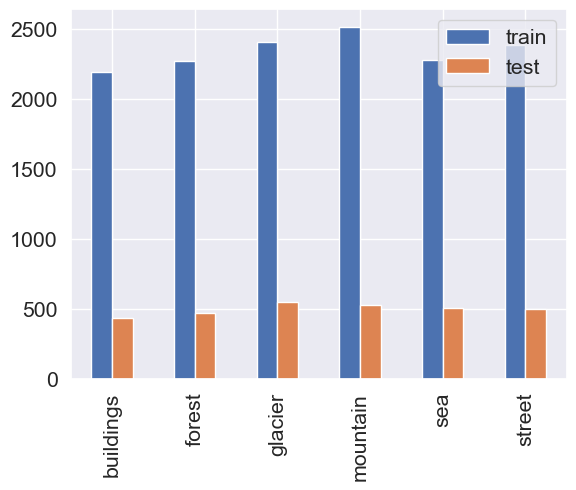

In [23]:
category_label=['buildings','forest', 'glacier','mountain','sea','street']
train_counts =[2191,2271,2404,2512,2274,2382]
test_counts = [437,474,553,525,510,501]
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=category_label
            ).plot.bar()
plt.show()

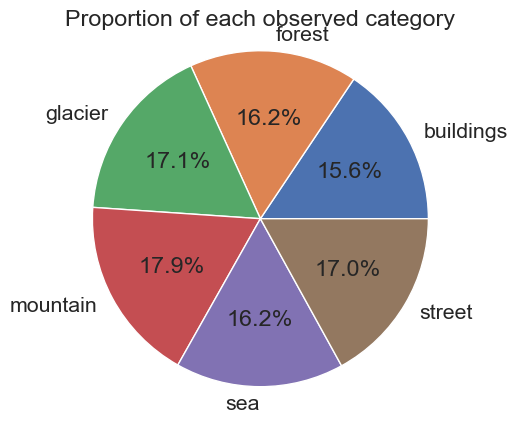

In [24]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=category_label,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

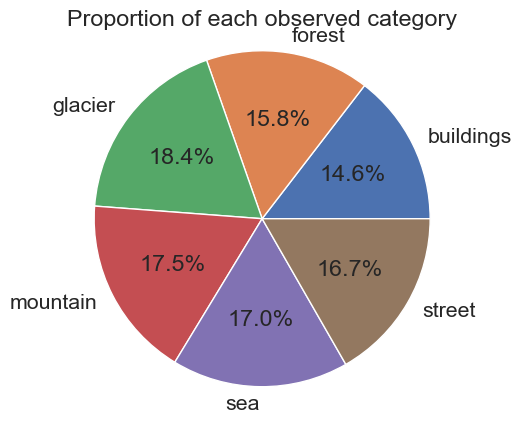

In [25]:
plt.pie(test_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=category_label,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Visualize the data
We can display a random image from the training set.

In [26]:
def display_random_image(category_label, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + category_label[labels[index]])
    plt.show()

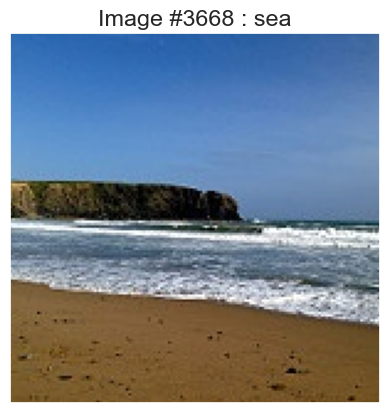

In [27]:
display_random_image(category_label, train_images, train_labels)

We can also display the first 25 images from the training set directly with a loop to get a better view

In [28]:
def display_examples(category_label, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(category_label[labels[i]])
    plt.show()

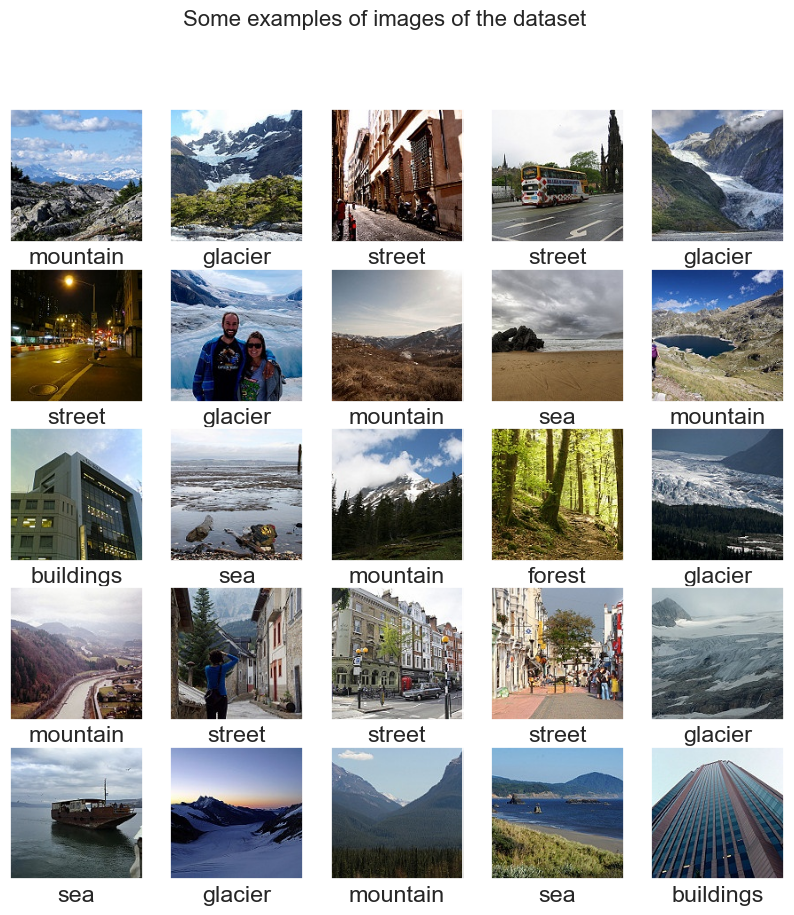

In [29]:
display_examples(category_label, train_images, train_labels)

# Beginner: Simple Model Creation

Steps are:
1. Build the model,
1. Compile the model,
1. Train / fit the data to the model,
1. Evaluate the model on the testing set,
1. Carry out an error analysis of our model.

We can build an easy model composed of different layers such as:
* Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
* MaxPooling2D: The images get half sized.
* Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
* Relu  : given a value x, returns max(x, 0).
* Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Then, we can compile it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.
What is Momentum and RMSProp ?
* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [31]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

We fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [32]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=40, validation_split = 0.2)

Epoch 1/5
88/88 [==============================] - 280s 3s/step - loss: 1.3433 - accuracy: 0.5121 - val_loss: 0.8764 - val_accuracy: 0.6844
Epoch 2/5
88/88 [==============================] - 300s 3s/step - loss: 0.7561 - accuracy: 0.7241 - val_loss: 0.7596 - val_accuracy: 0.7207
Epoch 3/5
88/88 [==============================] - 283s 3s/step - loss: 0.6012 - accuracy: 0.7836 - val_loss: 0.6927 - val_accuracy: 0.7499
Epoch 4/5
88/88 [==============================] - 289s 3s/step - loss: 0.4733 - accuracy: 0.8350 - val_loss: 0.6660 - val_accuracy: 0.7713
Epoch 5/5
88/88 [==============================] - 860s 10s/step - loss: 0.3468 - accuracy: 0.8850 - val_loss: 0.7099 - val_accuracy: 0.7652


In [33]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

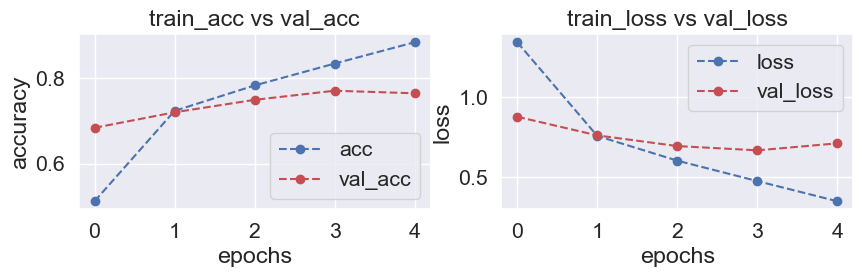

In [35]:
plot_accuracy_loss(history)

We should evaluate the model performance on test set

In [36]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 20s 210ms/step - loss: 0.7472 - accuracy: 0.7427


We see that we achieve 0.76 accuracy on the testing test. We got a slight underfitting :(

Let's see how the classifier is doing on random images.

94/94 [==============================] - 19s 197ms/step


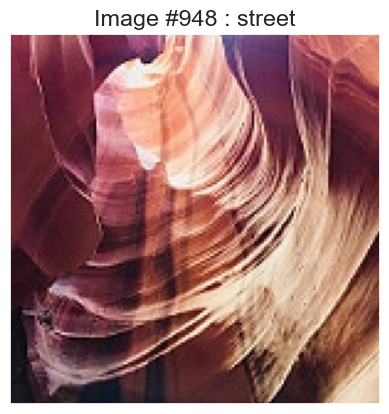

In [37]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(category_label, test_images, pred_labels)

## Error analysis

We can try to understand on which kind of images the classifier has trouble.

In [38]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


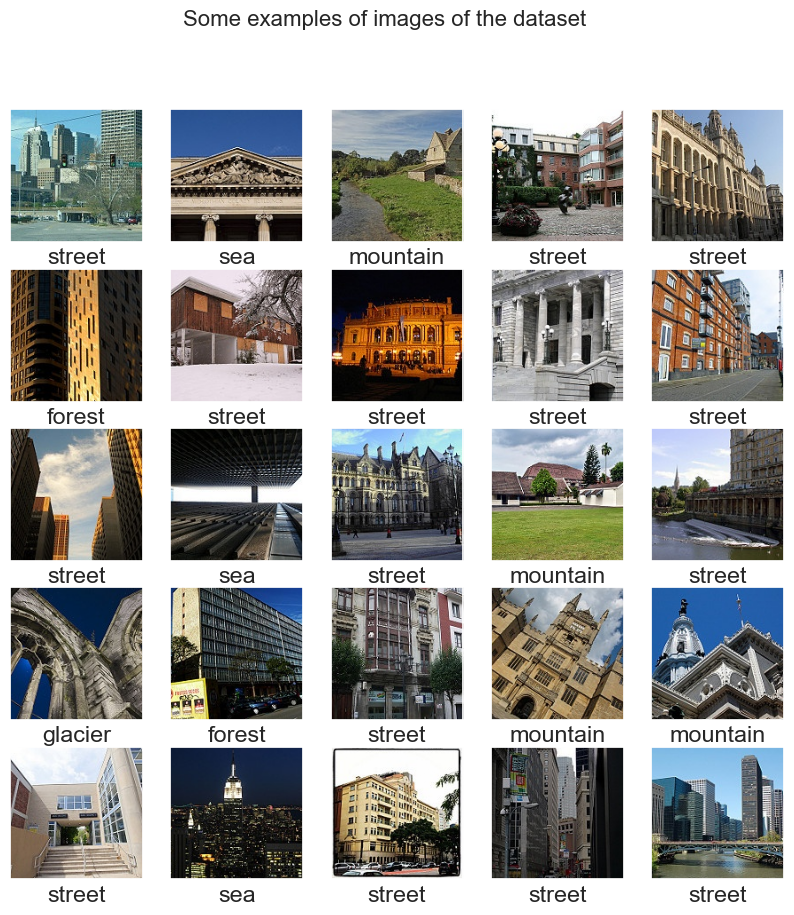

In [39]:
print_mislabeled_images(category_label, test_images, test_labels, pred_labels)

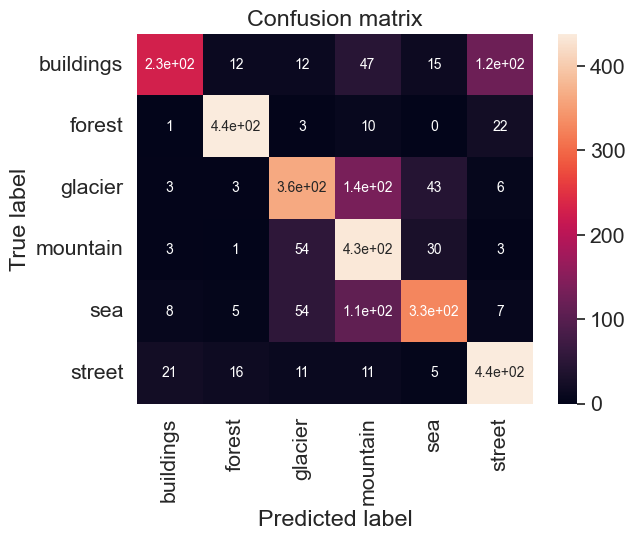

In [40]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=category_label, 
           yticklabels=category_label, ax = ax)
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

## Conclusion: The classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. Well, it can be understandable as as there are buildings in the street. 
It has also trouble with sea, glacier and moutain as well. It is hard for me to fully distinguish them.
However, it can detects forest very accurately!

In [41]:
# KVAR:
# CLASSIFICATION REPORT
# EGNA BILDER 

In [44]:
from sklearn import metrics
y_pred = model.predict(test_images)
print(y_pred) # se till att den endast tar ett prediction value //André
#print(metrics.classification_report(test_labels, y_pred, target_names=category_label))

94/94 [==============================] - 22s 232ms/step
[[7.8778166e-01 1.3395805e-05 1.1583406e-02 1.1969919e-01 8.0457360e-02
  4.6493590e-04]
 [7.7750012e-02 1.7055862e-02 1.7013538e-03 3.4755021e-02 4.0791914e-05
  8.6869687e-01]
 [9.8198789e-01 2.2089289e-04 1.5299040e-04 3.6421220e-03 2.9825277e-04
  1.3697808e-02]
 ...
 [1.4964317e-03 3.5526911e-05 8.2811841e-04 9.7501278e-01 2.2578118e-02
  4.9072652e-05]
 [2.9476795e-01 1.2371148e-04 1.6918355e-04 1.0711979e-02 2.0413448e-03
  6.9218588e-01]
 [1.0456090e-02 1.0882158e-01 1.8421015e-05 8.2756887e-06 3.9706484e-07
  8.8069522e-01]]


In [ ]:
def processing(path):
    img = cv2.imread(path)
    test1_proc = image2.load_img(path , target_size=(150,150))
    test1_proc_1 = image2.img_to_array(test1_proc)
    t1 = np.expand_dims(test1_proc ,axis=0)
    t1 = t1/255
    pred_classes = model.predict(t1)
    pred = np.argmax(pred_classes ,axis=1)

    plt.subplot(121)
    pic = Image.open(path) 
    plt.xlabel("Original Image")
    plt.imshow(pic)
    
    
    plt.subplot(122)

    s1 = pd.Series(pred_classes.ravel() , index = category_label)
    s1.plot(kind = 'bar' ,figsize = (10,5))
    plt.xlabel("prediction")
    
    plt.show()

    #for i in training_image.class_indices:
    #    if pred == training_image.class_indices[i]:
    #        print("prediction made by model is :" ,i)

1/1 [==============================] - 0s 28ms/step


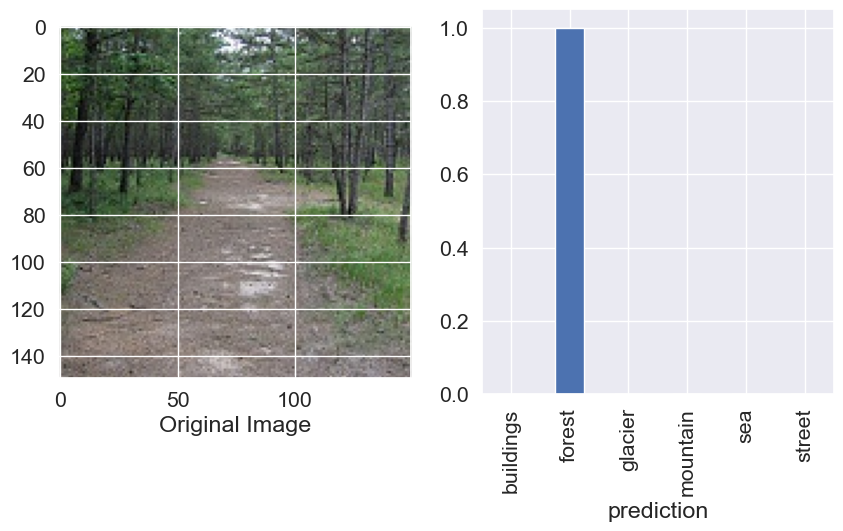

1/1 [==============================] - 0s 28ms/step


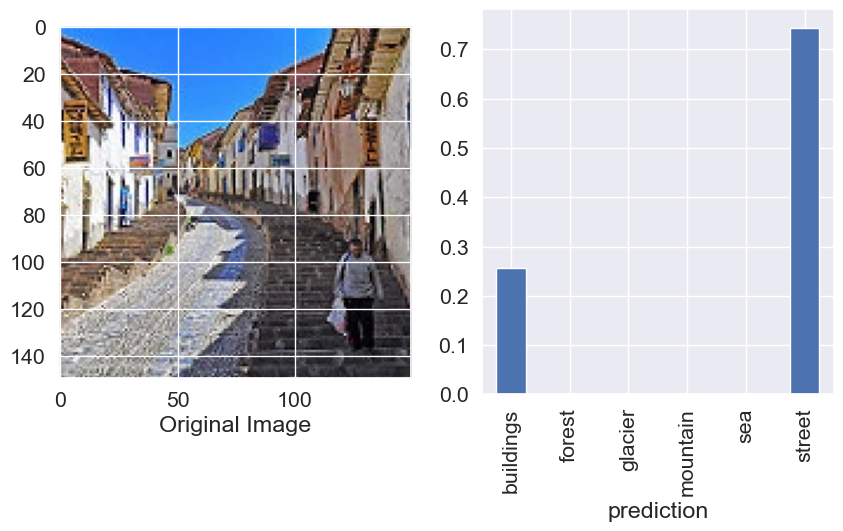

1/1 [==============================] - 0s 27ms/step


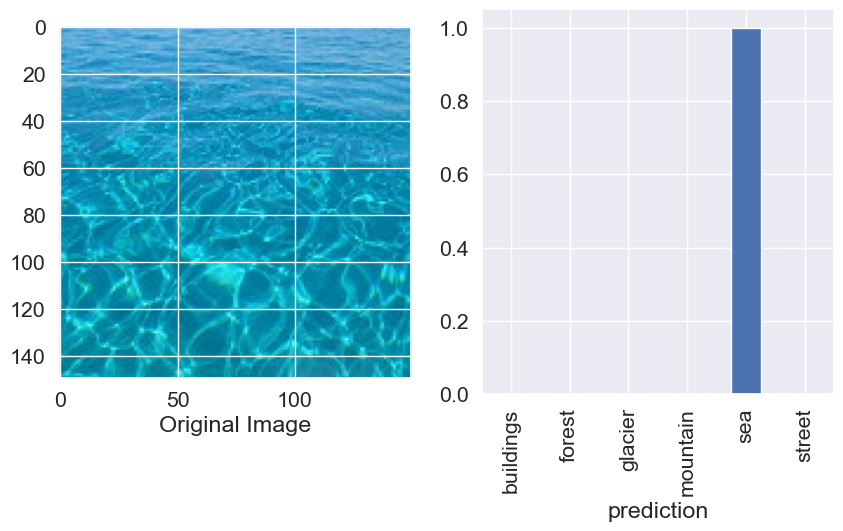

In [ ]:
processing(seg_test_path + "/forest/20056.jpg")
processing(test_street_path + "/20297.jpg")
processing(test_sea_path + "//21259.jpg")

# Our images

1/1 [==============================] - 0s 26ms/step


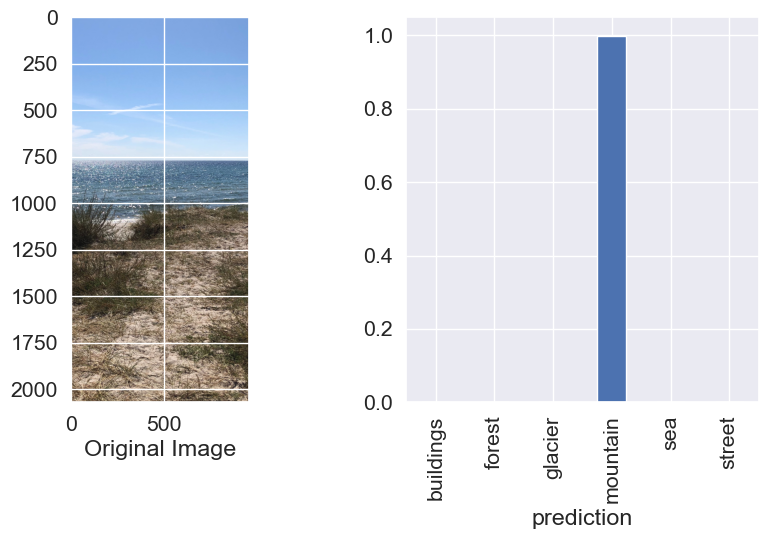

1/1 [==============================] - 0s 27ms/step


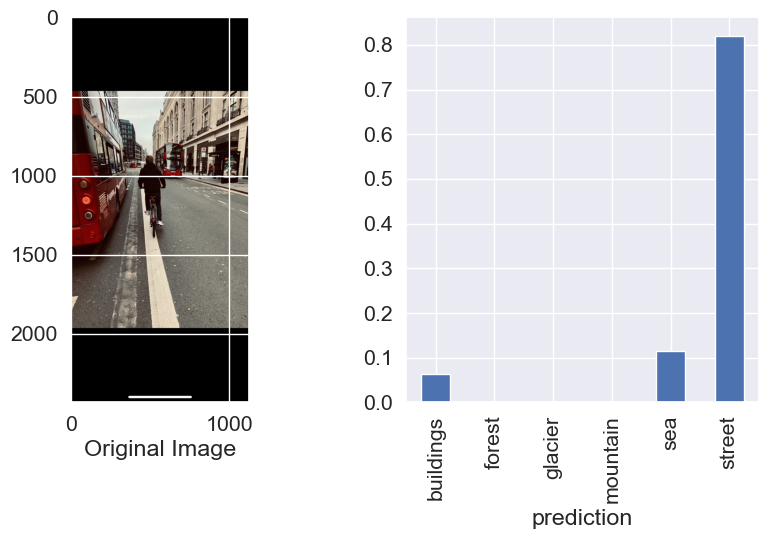

1/1 [==============================] - 0s 27ms/step


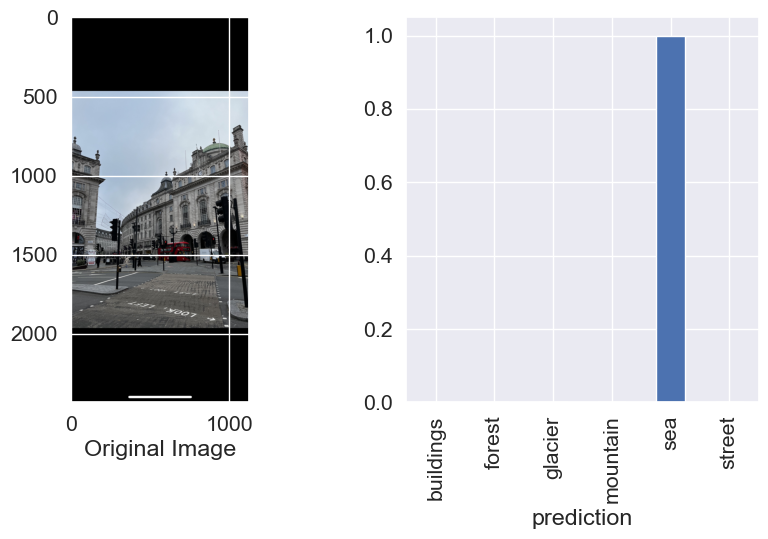

1/1 [==============================] - 0s 23ms/step


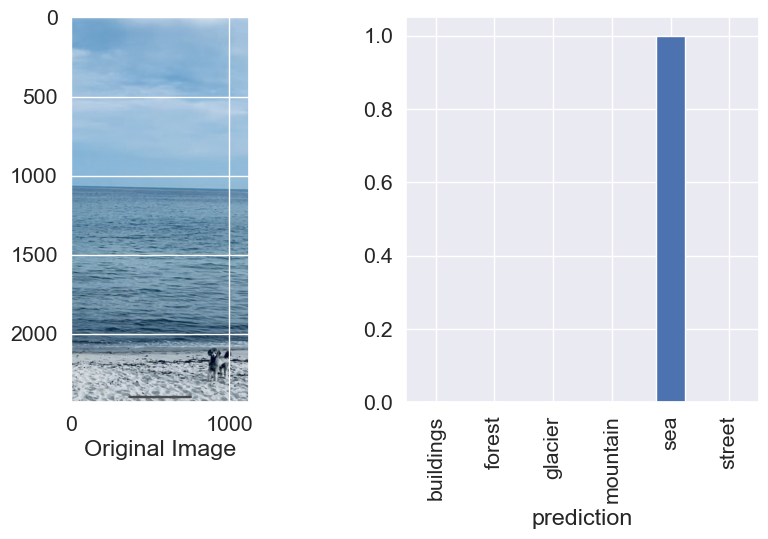

1/1 [==============================] - 0s 23ms/step


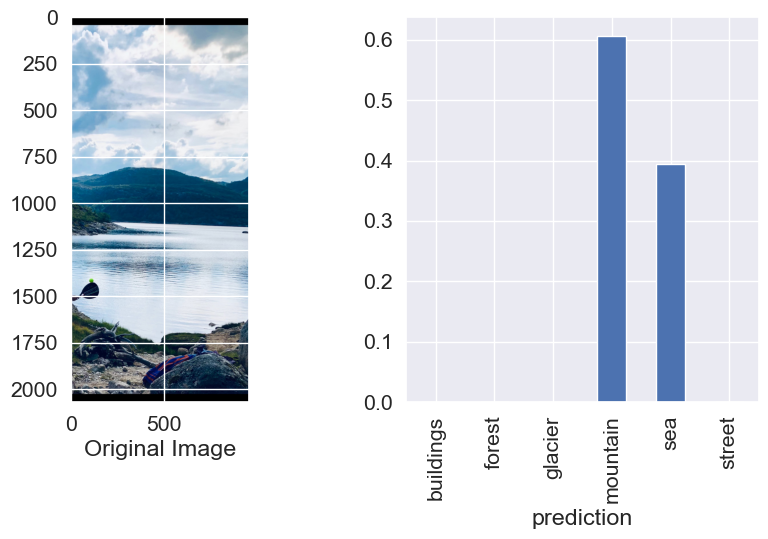

1/1 [==============================] - 0s 24ms/step


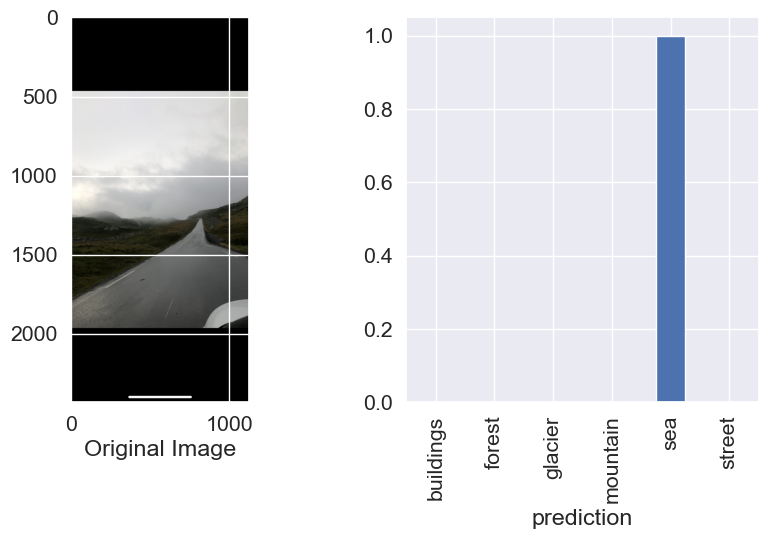

1/1 [==============================] - 0s 26ms/step


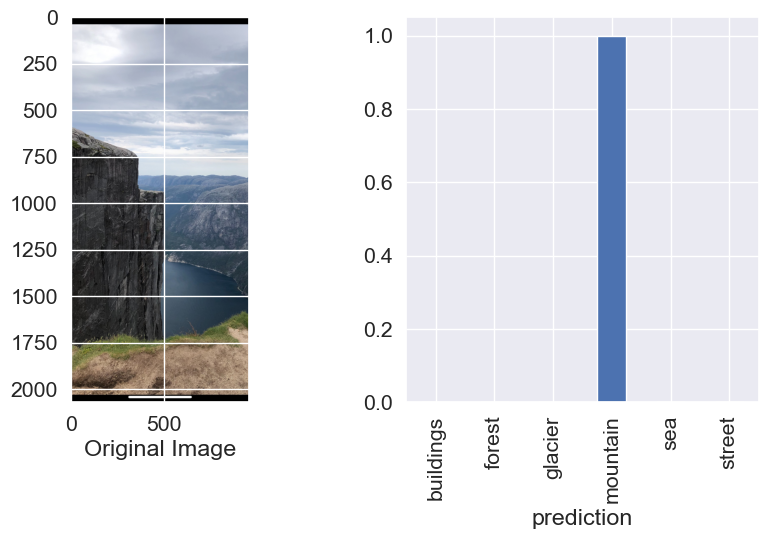

1/1 [==============================] - 0s 26ms/step


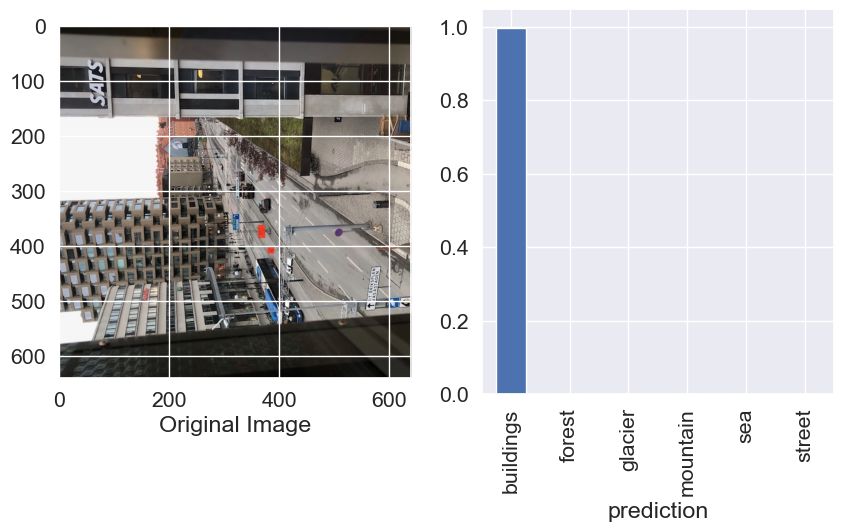

1/1 [==============================] - 0s 26ms/step


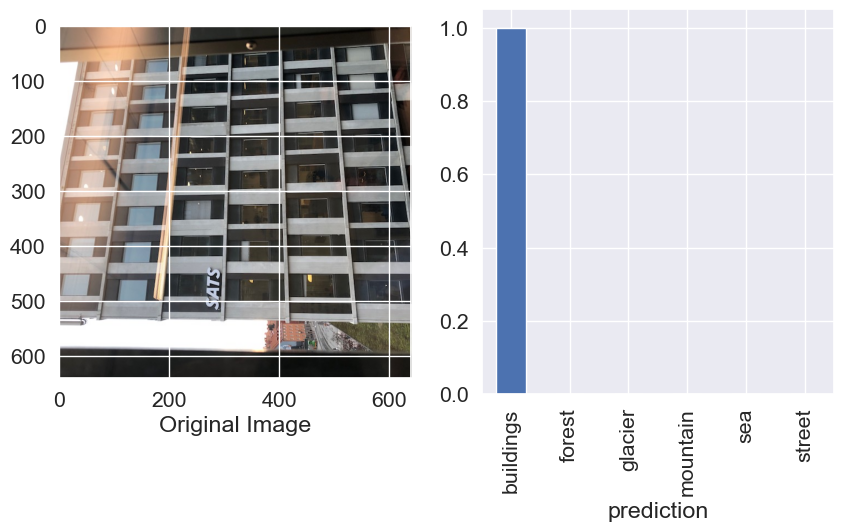

In [ ]:
sebbe_list = ['1','2','3','4','5','6','7','8','9']
for number in sebbe_list:
    processing(seg_our_path + f"//sebbe{number}.jpg")